In [ ]:
# Corey: another classfier , maybe k folds and do the statistically analysis compare with others (if it doesn't take too long)
# I already ran keras 10 folds, so you don't need to re-run it
# Keras 10 folds value is :
# [0.88497216, 0.87198514, 0.88497216, 0.90909094, 0.89239335, 0.90538031, 0.89981449, 0.88868272, 0.89405203, 0.87360597

# Kivanc: classiers' TF,callback, ROC, cm ?  

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from tensorflow.keras import backend
from keras import backend as K
import tensorflow as tf
import random
import collections
from keras.layers import Dropout
from keras.models import Sequential 
from keras.layers import Dense 
from pathlib import Path
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from six import StringIO
from copy import copy
from scipy import stats
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def encodeWithBLOSUM62(amino_acids):
    ## a function that returns the blosum62 vector given a certain aa 
    return list(BLOSUM62_MATRIX[amino_acids].values)

def blosumEncoding(data):
    ## a function that creates amino acid sequence that encode by blosum62 matrix 
    total_data_row =[]
    for each in data:
    
        eachrow =[]
        for aa in each:
            eachrow = eachrow+ encodeWithBLOSUM62(aa)
    
        total_data_row.append(eachrow)
    
    return pd.DataFrame(total_data_row)

def split(word): 
    return [char for char in word] 

COMMON_AMINO_ACIDS = collections.OrderedDict(sorted({
   "A": "Alanine",
   "R": "Arginine",
   "N": "Asparagine",
   "D": "Aspartic Acid",
   "C": "Cysteine",
   "E": "Glutamic Acid",
   "Q": "Glutamine",
   "G": "Glycine",
   "H": "Histidine",
   "I": "Isoleucine",
   "L": "Leucine",
   "K": "Lysine",
   "M": "Methionine",
   "F": "Phenylalanine",
   "P": "Proline",
   "S": "Serine",
   "T": "Threonine",
   "W": "Tryptophan",
   "Y": "Tyrosine",
   "V": "Valine",
   }.items()))
COMMON_AMINO_ACIDS_WITH_UNKNOWN = copy(COMMON_AMINO_ACIDS)
COMMON_AMINO_ACIDS_WITH_UNKNOWN["X"] = "Unknown"
   
AMINO_ACID_INDEX = dict((letter, i) for (i, letter) in enumerate(COMMON_AMINO_ACIDS_WITH_UNKNOWN))

AMINO_ACIDS = list(COMMON_AMINO_ACIDS_WITH_UNKNOWN.keys())
   
BLOSUM62_MATRIX = pd.read_csv(StringIO("""
  A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  X
   A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0  0
   R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3  0
   N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  0
   D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  0
   C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1  0
   Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0
   E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  0
   G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3  0
   H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0
   I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3  0
   L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1  0
   K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0
   M -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1  0
   F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1  0
   P -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2  0
   S  1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0
   T  0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0  0 
   W -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3  0
   Y -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1  0
   V  0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4  0
   X  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   """), sep='\s+').loc[AMINO_ACIDS, AMINO_ACIDS].astype("int8")
assert (BLOSUM62_MATRIX == BLOSUM62_MATRIX.T).all().all() 



Using TensorFlow backend.


In [3]:
## Data preprocessing, importing the dataset
## need to change the file location
workdir = Path('/Users/kivanc/DataMining-ML/Projects/MiniProject2')
dataset = pd.read_csv(workdir/"HLA-A-01.txt",sep='\t')

peptides = dataset.peptide.values
final_peptide = [split(each_peptide) for each_peptide in peptides]

## encode y label
from sklearn import preprocessing
y = dataset.Binder.values
le = preprocessing.LabelEncoder()
a = le.fit(y)
y= le.transform(y)

## encode x label using bl62 matrix
X = blosumEncoding(final_peptide).values
## to see the dataset distribution 
#dataset.groupby('Binder').size()
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
val_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True,stratify = y)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=val_size, random_state = 0, shuffle=True)


In [98]:
print(dataset.head())

        allele    peptide  measurement_value measurement_inequality  \
0  HLA-A*01:01  AAAALGRAP              100.0                      <   
1  HLA-A*01:01  AADFPGIAR            20000.0                      >   
2  HLA-A*01:01  AADIFYSRY              100.0                      <   
3  HLA-A*01:01  AADKAAAAY               50.0                      =   
4  HLA-A*01:01  AADLNLVLY              100.0                      <   

  measurement_type measurement_kind  \
0      qualitative        mass_spec   
1     quantitative         affinity   
2      qualitative        mass_spec   
3     quantitative         affinity   
4      qualitative        mass_spec   

                               measurement_source original_allele  fold_0  \
0           Neri - cellular MHC/mass spectrometry     HLA-A*01:01    True   
1         Buus - purified MHC/direct/fluorescence     HLA-A*01:01    True   
2         Peters - secreted MHC/mass spectrometry     HLA-A*01:01    True   
3  Sette - purified MHC/compet

Train on 5388 samples, validate on 599 samples
Epoch 1/200
5388/5388 [==============================] - 0s 65us/step - loss: 0.3857 - accuracy: 0.8268 - val_loss: 0.3037 - val_accuracy: 0.8781
Epoch 2/200
5388/5388 [==============================] - 0s 24us/step - loss: 0.3273 - accuracy: 0.8614 - val_loss: 0.2902 - val_accuracy: 0.8681
Epoch 3/200
5388/5388 [==============================] - 0s 26us/step - loss: 0.3159 - accuracy: 0.8649 - val_loss: 0.2901 - val_accuracy: 0.8881
Epoch 4/200
5388/5388 [==============================] - 0s 23us/step - loss: 0.3044 - accuracy: 0.8719 - val_loss: 0.2735 - val_accuracy: 0.8898
Epoch 5/200
5388/5388 [==============================] - 0s 22us/step - loss: 0.3025 - accuracy: 0.8732 - val_loss: 0.2853 - val_accuracy: 0.8898
Epoch 6/200
5388/5388 [==============================] - 0s 25us/step - loss: 0.2945 - accuracy: 0.8816 - val_loss: 0.2695 - val_accuracy: 0.8932
Epoch 7/200
5388/5388 [==============================] - 0s 23us/step - loss:

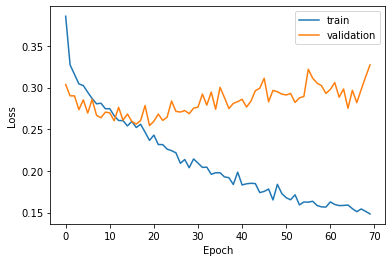

	True	False
True	579	65
Flase	114	739
--------------------
accuracy: 0.8804275217100869
	True	False
True	557	87
Flase	93	760
--------------------
accuracy: 0.8797595190380761
	True	False
True	530	114
Flase	67	786
--------------------
accuracy: 0.8790915163660654
0.8804275393486023


In [6]:
## Create an ANN model
# Training the model
# Dense object will take care to initialize the random number close to 0 ( first ANN step)
classifier = Sequential() # use the sequential layer
classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,   kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
## here is the output layer
## if we deal with more than 2 categories, the activation function needs to use softmax
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
opt = keras.optimizers.rmsprop(learning_rate= 0.001)
# Compiling the ANN
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience= 50)
# check the model performance and save the best model
mc = ModelCheckpoint('/Users/kivanc/DataMining-ML/Projects/MiniProject2/Minproject2best_50batch_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = classifier.fit(X_train, y_train, validation_data= (X_val,y_val), batch_size = 50, epochs = 200, callbacks = [mc,es])

# the plot to see the lose function during the training process in training dataset and validation dataset

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
history.history['loss']

# Predicting the Test set results
y_pred = classifier.predict(X_test)


## the output give the probability and we apply the cut off to decide if the peptide is a binder or not
# Here I just want to know if we apply different cutoff, would it create different results?
thresheld = [0.5,0.7,0.9]
y_pred_list =[]
for i in thresheld:
    y_pred_value = (y_pred > i).tolist()
    y_pred_list.append(y_pred_value)
    
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
cm_list=[]
for i in range(len(y_pred_list)):
    cm = confusion_matrix(y_test, y_pred_list[i],labels=[1,0])
    cm_list.append(cm)
    print("","True","False",sep="\t")
    print("True",cm[0,0],cm[0,1],sep="\t" )
    print("Flase",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    print("accuracy:", metrics.accuracy_score(y_pred_list[i],y_test))   


test_loss, test_acc = classifier.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [7]:
## Stratified Kfold with Keras
## if your computer is not mac, the n_jobs = 1

def build_classifier():
    classifier = Sequential() # use the sequential layer
    ## init = kernel_initializer
    classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 189))
    ## if we deal with more than 2 categories, the activation function needs to use softmax
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    opt = keras.optimizers.rmsprop(learning_rate= 0.001)
    # Compiling the ANN
    classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 50, epochs = 200)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = kfold, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

## Model Evaluation
### Kivanc

In [68]:
## Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    source: http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

[[579  65]
 [114 739]]


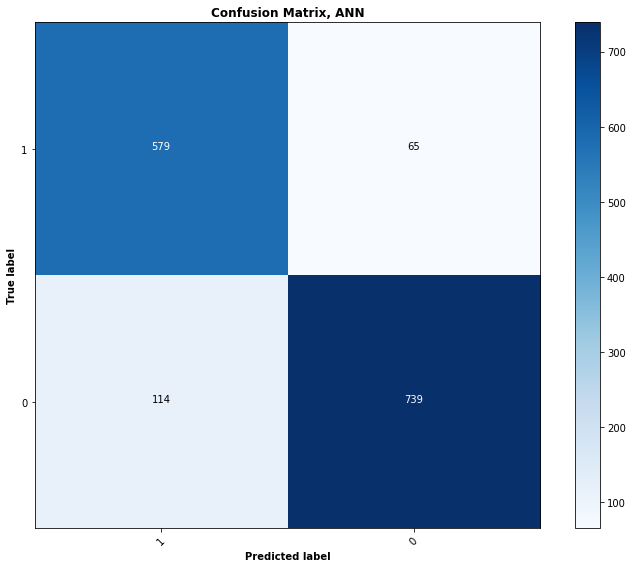

In [69]:
## Compute and plot the confusion matrix for the ANN model
cm_ANN = confusion_matrix(y_test, y_pred.round(), labels=[1, 0])
print(cm_ANN)
plt.figure(figsize=(10,8))
plot_confusion_matrix(cm_ANN, classes=[1, 0],
                      title='Confusion Matrix, ANN')
plt.savefig('fig1.png')

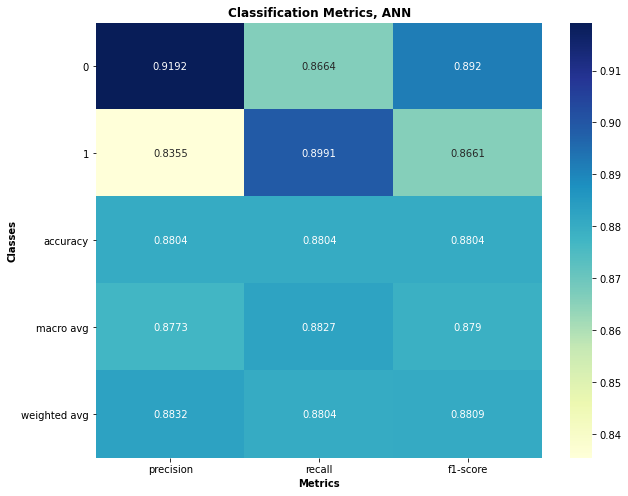

In [70]:
## Compute and plot the classification metrics for the ANN model

from sklearn.metrics import classification_report
import seaborn as sns

report_ANN = classification_report(y_test, y_pred.round(), output_dict=True)
report_ANN = pd.DataFrame(report_ANN).transpose()
report_ANN.to_csv ("//Users/kivanc/DataMining-ML/Projects/MiniProject2/report_ANN.csv", index = True, header=True)

plt.figure(figsize=(10,8))
fig_class = sns.heatmap(pd.DataFrame(report_ANN).iloc[:, :-1], annot=True, cmap="YlGnBu", fmt=".4g")
plt.title("Classification Metrics, ANN", fontweight='bold')
plt.xlabel('Metrics', fontweight='bold') # x-axis label with fontsize 15
plt.ylabel('Classes', fontweight='bold') # y-axis label with fontsize 15
plt.yticks(rotation=0)
plt.savefig('fig2.png')

In [94]:
def make_ROC(data_actual, data_predict):
    """
    Function to compute ROC. Takes two
    parameters: first is actual scores,
    and second is predicted scores.
    """
    N=len(data_actual)

    TPF=[]
    FPF=[]
    threshold=0
    j=0
    increment=1/N

    while(threshold<=1.1):
        #threshold=i
        TP, FP, TN, FN = 0, 0, 0, 0
        # Accumulate the true/false negative/positives
        for j in range(N):
            if data_actual[j]==1:
                if data_predict[j]>=threshold:
                    TP+=1
                else:
                    FN+=1
            if data_actual[j]==0:
                if data_predict[j]>=threshold:
                    FP+=1
                else:
                    TN+=1

        # Calcualate true positive rate for current threshold.           
        TP_Rate=TP/(TP + FN)

        # Calcualate false positive rate for current threshold. 
        FP_Rate=FP/(FP + TN)

        TPF.append(TP_Rate)
        FPF.append(FP_Rate)

        threshold+=increment

    return TPF, FPF

def plot_ROC(data_actual, data_predict):
    """
    Function to make ROC curve plot. Takes false
    positive rate and true positive rates list as
    parameters.
    """
    # Get True Positive Rate and False Positive Rate lists
    TPF, FPF = make_ROC(data_actual, data_predict)
    auc = -1 * np.trapz(TPF, FPF)
    # Plot the ROC curve
    fig = plt.figure(figsize=(10,8))
    plt.title('ROC Curve')
    plt.plot(FPF, TPF, marker='.', label='ROC Curve')
    plt.plot([0, 1], ls="--", label='Random Classifier')
    plt.title('ROC Curve, ANN (AUC = %.2f)'%auc, fontweight='bold')
    plt.xlabel('False Positive Rate (FPR)', fontweight='bold')
    plt.ylabel('True Positive Rate (TPR)', fontweight='bold')
    plt.legend()
    plt.show()

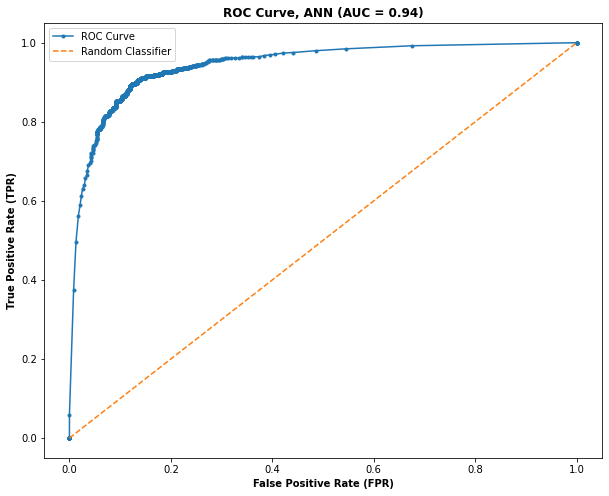

In [95]:

## Plot the ROC curve
plot_ROC(y_test, y_pred)